## 1. Environment Setup  
First clone the GitHub repo, install dependencies, and set the working directory so that all data and modules are accessible.

In [ ]:
# Cell 0  ▸  clone the repo and enter it
REPO_URL = "https://github.com/KeysGui-i/189G_final.git"   # ← your repo
REPO_DIR = "189G_final"                                    # folder name after clone

import os, subprocess, sys, pathlib

if not pathlib.Path(REPO_DIR).exists():
    # If the repo is private, use: https://<TOKEN>@github.com/KeysGui-i/189G_final.git
    !git clone --depth 1 {REPO_URL}

%cd {REPO_DIR}


Cloning into '189G_final'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 3), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 2.95 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/189G_final


In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential, Model

## 2. Load & Inspect Data  
Read in the raw NSL-KDD CSVs, specify feature names, and preview the DataFrame dimensions.


In [ ]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [ ]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data/raw")        # ✓ now correct

train_data  = pd.read_csv(DATA_DIR / "KDDTrain+.txt",  names=feature)
test_data   = pd.read_csv(DATA_DIR / "KDDTest+.txt",   names=feature)
test21_data = pd.read_csv(DATA_DIR / "KDDTest-21.txt", names=feature)
data= pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)

## 3. Exploratory Data Analysis  
- Check for missing values  
- View summary statistics  
- Examine class imbalance across attack types


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,148517.0,276.779305,2.460683e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,148517.0,40227.949299,5.409612e+06,0.0,0.00,44.00,278.00,1.379964e+09
dst_bytes,148517.0,17088.853593,3.703525e+06,0.0,0.00,0.00,571.00,1.309937e+09
land,148517.0,0.000215,1.467714e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,148517.0,0.020523,2.400691e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,148517.0,0.000202,1.941708e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,148517.0,0.189379,2.013160e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,148517.0,0.004323,7.224823e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,148517.0,0.402789,4.904606e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,148517.0,0.255062,2.223137e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [ ]:
# number of attack labels
data['label'].value_counts()

,count
label,
normal,77054
neptune,45871
satan,4368
ipsweep,3740
smurf,3311
portsweep,3088
nmap,1566
back,1315
guess_passwd,1284


### 3.1 Consolidate Attack Categories  
Combine the original 20+ attack types into the five broad classes: DOS, Probe, R2L, U2R, and Normal.


In [ ]:
# Redistribute across common attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
change_label(data)

<ipython-input-10-81846d81b261>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


In [ ]:
# distribution of attack classes
data.label.value_counts()

,count
label,
normal,77054
Dos,53387
Probe,14077
R2L,3880
U2R,119


### Protocol

In [ ]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)

In [ ]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)


In [ ]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,normal,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,Dos,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4


## 4. Data Preprocessing  
1. Drop raw `label` column  
2. Standard‐scale continuous features  
3. Label‐encode the multi‐class target  
4. One‐hot‐encode any remaining categoricals



In [ ]:
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)


(148517, 42)


In [ ]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
print(data.shape)

(148517, 123)


In [ ]:
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

### 4.1 Train/Test Split  
Reserve 20% of data for testing, with a fixed random seed for reproducibility.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

## 5. Model Architecture  
Using a time-series LSTM/stacked autoencoder, ending in a softmax for 5-way classification.


In [ ]:
model = Sequential() # initializing model
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# summary of model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,425 (458.69 KB)

 Trainable params: 117,425 (458.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# cast to float32 (True→1.0, False→0.0)
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)

# if your labels are integers (e.g. 0,1,2…), ensure they’re int32
y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

# now your dtype should be float32 / int32
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train dtype: float32
y_train dtype: int32


### 5.1 Model Training  
- Optimizer: Adam  
- Loss: Categorical crossentropy  
- Metrics: Accuracy  



In [ ]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.6485 - loss: 1.5611 - val_accuracy: 0.8329 - val_loss: 1.3019
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8337 - loss: 1.0945 - val_accuracy: 0.8396 - val_loss: 0.5368
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8469 - loss: 0.4915 - val_accuracy: 0.8500 - val_loss: 0.4203
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8527 - loss: 0.4055 - val_accuracy: 0.8615 - val_loss: 0.3665
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8732 - loss: 0.3543 - val_accuracy: 0.9227 - val_loss: 0.3059
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9264 - loss: 0.2902 - val_accuracy: 0.9409 - val_loss: 0.2233
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9414 - loss: 0.2092 - val_accuracy: 0.9448 - val_loss: 0.1711
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9451 - loss: 0.1702 - val_accu

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9894 - loss: 0.0350
Test results - Loss: 0.03678341209888458 - Accuracy: 98.85873794555664%


## 6. Baseline Performance on Clean Data  
Evaluate precision, recall, F1-score, and accuracy before any adversarial perturbations.


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_trues = []

for x_b, y_b in test_ds:
    logits = model(x_b, training=False)
    preds  = tf.argmax(logits, axis=1).numpy()    # (batch,)
    trues  = tf.argmax(y_b, axis=1).numpy()       # (batch,)
    all_preds.extend(preds.tolist())
    all_trues.extend(trues.tolist())

target_names = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
report = classification_report(all_trues, all_preds, target_names=target_names, digits=2)
print("=== Baseline (Clean) Classification Report ===")
print(report)


=== Baseline (Clean) Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     10688
         DoS       0.97      0.99      0.98      2749
       Probe       0.90      0.87      0.89       792
         R2L       0.75      0.60      0.67        25
         U2R       0.99      0.99      0.99     15450

    accuracy                           0.99     29704
   macro avg       0.92      0.89      0.90     29704
weighted avg       0.99      0.99      0.99     29704



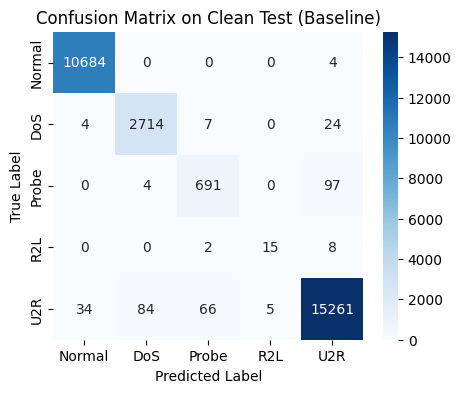

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


all_preds_clean = []
all_trues_clean = []

for x_b, y_b in test_ds:
    logits = model(x_b, training=False)
    preds  = tf.argmax(logits, axis=1).numpy()
    trues  = tf.argmax(y_b, axis=1).numpy()
    all_preds_clean.extend(preds.tolist())
    all_trues_clean.extend(trues.tolist())

cm_clean = confusion_matrix(all_trues_clean, all_preds_clean)  # shape = (5,5)


plt.figure(figsize=(5,4))
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Clean Test (Baseline)')
plt.show()


## 7. Adversarial Attack Evaluation  
Applying the Fast Gradient Sign Method (FGSM) at various ε levels to measure robustness degradation.
*italicized text*

In [ ]:

import tensorflow as tf

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def make_fgsm(model, x, y, epsilon=0.02):
    """
    Generate FGSM adversarial examples:
      x_adv = x + epsilon * sign(∇_x loss(model(x), y))
    clipped to [0,1].
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)
        loss   = loss_fn(y, logits)
    grad = tape.gradient(loss, x)

    # Cast epsilon to x's dtype to avoid float64/float32 mismatch
    eps = tf.cast(epsilon, x.dtype)
    x_adv = x + eps * tf.sign(grad)
    return tf.clip_by_value(x_adv, 0.0, 1.0)


Baseline: FGSM on clean dataset



In [ ]:


from sklearn.model_selection import train_test_split


X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.10,
    random_state=42,
    stratify=y_train
)


batch_size = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_sub, y_train_sub))
    .shuffle(buffer_size=len(X_train_sub), seed=42)
    .batch(batch_size)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
)


test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(batch_size)
)


In [ ]:
test_epsilons = [0.01, 0.02, 0.05, 0.10]
baseline_adv_acc = {}

for eps in test_epsilons:
    total_correct = 0
    total_samples = 0
    for x_b, y_b in test_ds:
        x_adv = make_fgsm(model, x_b, y_b, epsilon=eps)
        logits_adv = model(x_adv, training=False)
        preds_adv  = tf.argmax(logits_adv, axis=1).numpy()
        trues_adv  = tf.argmax(y_b, axis=1).numpy()
        total_correct += np.sum(preds_adv == trues_adv)
        total_samples += x_b.shape[0]

    adv_acc_pct = 100.0 * total_correct / total_samples
    baseline_adv_acc[eps] = adv_acc_pct
    print(f"Baseline @ ε={eps:.3f} → Adversarial Accuracy: {adv_acc_pct:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Baseline @ ε=0.010 → Adversarial Accuracy: 74.90%
Baseline @ ε=0.020 → Adversarial Accuracy: 65.55%
Baseline @ ε=0.050 → Adversarial Accuracy: 32.10%
Baseline @ ε=0.100 → Adversarial Accuracy: 7.77%


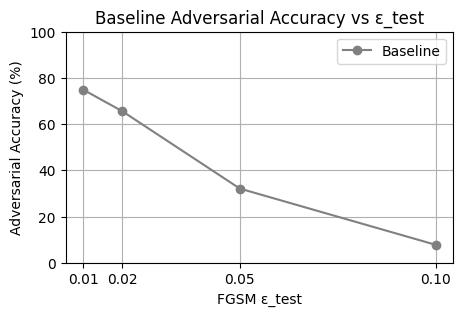

In [ ]:
import matplotlib.pyplot as plt


eps_list = list(baseline_adv_acc.keys())
acc_list = [baseline_adv_acc[eps] for eps in eps_list]

plt.figure(figsize=(5,3))
plt.plot(eps_list, acc_list, marker='o', color='gray', label='Baseline')
plt.xlabel('FGSM ε_test')
plt.ylabel('Adversarial Accuracy (%)')
plt.title('Baseline Adversarial Accuracy vs ε_test')
plt.xticks(eps_list)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


## 8. Start full adversarial retrain

In [ ]:


def full_adversarial_train(
    base_model,
    train_dataset,
    val_dataset,
    eps_train=0.02,
    max_epochs=20,
    patience=5
):

    m = tf.keras.models.clone_model(base_model)
    m.set_weights(base_model.get_weights())
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_acc   = tf.keras.metrics.CategoricalAccuracy()

    best_val_loss = float("inf")
    wait_cnt = 0
    best_epoch = 0
    val_loss_history = []

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):

        train_acc.reset_state()

        for step, (x_b, y_b) in enumerate(train_dataset):

            x_adv = make_fgsm(m, x_b, y_b, epsilon=eps_train)


            x_mix = tf.concat([x_b, x_adv], axis=0)
            y_mix = tf.concat([y_b, y_b],     axis=0)


            with tf.GradientTape() as tape:
                logits = m(x_mix, training=True)
                loss   = loss_fn(y_mix, logits)
            grads = tape.gradient(loss, m.trainable_variables)
            opt.apply_gradients(zip(grads, m.trainable_variables))


            clean_logits = m(x_b, training=False)
            train_acc.update_state(y_b, clean_logits)

            if step % 50 == 0:
                print(f"Epoch {epoch:3d} | Step {step:4d} | "
                      f"loss: {loss:.4f} | clean-acc: {train_acc.result():.4f}")


        val_acc.reset_state()
        total_val_loss = 0.0
        total_samples  = 0

        for x_v, y_v in val_dataset:
            logits_v = m(x_v, training=False)
            loss_v   = loss_fn(y_v, logits_v)
            total_val_loss += loss_v.numpy() * x_v.shape[0]
            val_acc.update_state(y_v, logits_v)
            total_samples += x_v.shape[0]

        avg_val_loss = total_val_loss / total_samples
        val_loss_history.append(avg_val_loss)

        print(f"→ Epoch {epoch:3d} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc.result().numpy():.4f}")


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait_cnt = 0
            best_epoch = epoch
        else:
            wait_cnt += 1
            if wait_cnt >= patience:
                print(f"EarlyStopping at epoch {epoch} "
                      f"(no improvement in val_loss for {patience} rounds).")
                break

    total_time = time.time() - start_time
    print(f"\n>> Finished Full Adv Training (ε_train={eps_train}). "
          f"Best epoch = {best_epoch}. Total time = {total_time:.2f} s.\n")

    return m, total_time, best_epoch, val_loss_history


### 8.1 Perform full adversarial training with respect to FGSM at ε = 0.01 / 0.02 / 0.05 / 0.10

I fully retrain the detector from scratch with FGSM adversarial examples each epoch for ε_train ∈ {0.01, 0.02, 0.05, 0.10}:

1. **Setup**  
   - Clone `base_model` weights into a new model `m`.  
   - Optimizer: Adam (lr = 1e-3).  
   - Metrics: `CategoricalAccuracy` for training and validation.

2. **Custom Training Loop**  
   - **Per epoch**:  
     a. For each batch `(x_b, y_b)` in `train_ds`  
        - Generate adversarial `x_adv = make_fgsm(m, x_b, y_b, ε_train)`  
        - Stack clean & adv: `x_mix = [x_b; x_adv]`, `y_mix = [y_b; y_b]`  
        - Compute loss on `x_mix,y_mix`, apply gradients.  
        - Update train‐accuracy metric on clean logits.  
     b. Validate on `val_ds`, accumulate loss & update val‐accuracy.  
     c. Check early‐stopping (patience=5).

3. **Return**  
   - `(adv_model, train_time, best_epoch, val_loss_history)`

4. **Aggregate Results**  
   - Loop over ε_train values, store `adv_trained_models`, `train_times`, `best_epochs`.



===== Start Full Adv Retrain with ε_train = 0.01 =====


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch   1 | Step    0 | loss: 0.3733 | clean-acc: 0.9844
Epoch   1 | Step   50 | loss: 0.0868 | clean-acc: 0.9844
Epoch   1 | Step  100 | loss: 0.0351 | clean-acc: 0.9861
Epoch   1 | Step  150 | loss: 0.0390 | clean-acc: 0.9874
Epoch   1 | Step  200 | loss: 0.0964 | clean-acc: 0.9876
Epoch   1 | Step  250 | loss: 0.0451 | clean-acc: 0.9875
Epoch   1 | Step  300 | loss: 0.0690 | clean-acc: 0.9877
Epoch   1 | Step  350 | loss: 0.0420 | clean-acc: 0.9883
Epoch   1 | Step  400 | loss: 0.0942 | clean-acc: 0.9878
Epoch   1 | Step  450 | loss: 0.0497 | clean-acc: 0.9875
Epoch   1 | Step  500 | loss: 0.0211 | clean-acc: 0.9875
Epoch   1 | Step  550 | loss: 0.0614 | clean-acc: 0.9873
Epoch   1 | Step  600 | loss: 0.0235 | clean-acc: 0.9872
Epoch   1 | Step  650 | loss: 0.0522 | clean-acc: 0.9868
Epoch   1 | Step  700 | loss: 0.0215 | clean-acc: 0.9868
Epoch   1 | Step  750 | loss: 0.0891 | clean-acc: 0.9868
Epoch   1 | Step  800 | loss: 0.1004 | clean-acc: 0.9867
Epoch   1 | Step  850 | loss: 0

,train_time_s
epsilon_train,
0.01,6784.711349
0.02,7036.511056
0.05,6852.013970
0.10,7057.179197


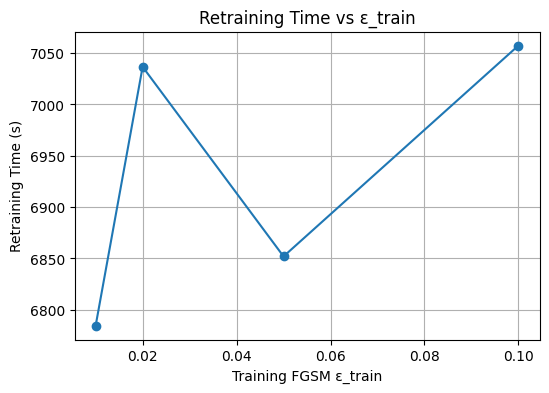

In [ ]:

import time

train_epsilons = [0.01, 0.02, 0.05, 0.10]

adv_trained_models = {}
train_times = {}
best_epochs  = {}

for eps in train_epsilons:
    print(f"\n===== Start Full Adv Retrain with ε_train = {eps} =====")

    adv_model, t_time, b_epoch, val_loss_hist = full_adversarial_train(
        base_model = model,
        train_dataset = train_ds,
        val_dataset   = val_ds,
        eps_train    = eps,
        max_epochs   = 20,
        patience     = 5
    )

    adv_trained_models[eps] = adv_model
    train_times[eps] = t_time
    best_epochs[eps]  = b_epoch

    print(f"--- ε_train={eps} retrain done: time = {t_time:.2f}s, best_epoch = {b_epoch} ---\n")


import pandas as pd
df_times = pd.DataFrame.from_dict(train_times, orient='index', columns=['train_time_s'])
df_times.index.name = 'epsilon_train'
display(df_times)


import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(df_times.index, df_times['train_time_s'], marker='o')
plt.xlabel('Training FGSM ε_train')
plt.ylabel('Retraining Time (s)')
plt.title('Retraining Time vs ε_train')
plt.grid(True)
plt.show()


## 8.2 Summary of the performance of full adversarial trained model at different epsilon value

Hyperparameters for Full Adversarial Training:
  • Optimizer: Adam(lr=1e-3)
  • Batch size: 64
  • EarlyStopping (patience = 5 epochs)
  • FGSM training epsilons:  [0.01, 0.02, 0.05, 0.1]

Clean Accuracy after Adversarial Training:
  ε_train = 0.01 → Clean Accuracy = 99.03%
  ε_train = 0.02 → Clean Accuracy = 99.09%
  ε_train = 0.05 → Clean Accuracy = 99.03%
  ε_train = 0.10 → Clean Accuracy = 99.07%

Adversarial Accuracy of Adv-Trained Models:
  --- ε_train = 0.01 ---


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    ε_test = 0.01 → Adv Accuracy = 98.39%
    ε_test = 0.02 → Adv Accuracy = 98.24%
    ε_test = 0.05 → Adv Accuracy = 97.52%
    ε_test = 0.10 → Adv Accuracy = 94.54%

  --- ε_train = 0.02 ---
    ε_test = 0.01 → Adv Accuracy = 98.51%
    ε_test = 0.02 → Adv Accuracy = 98.41%
    ε_test = 0.05 → Adv Accuracy = 97.88%
    ε_test = 0.10 → Adv Accuracy = 96.19%

  --- ε_train = 0.05 ---
    ε_test = 0.01 → Adv Accuracy = 98.41%
    ε_test = 0.02 → Adv Accuracy = 98.67%
    ε_test = 0.05 → Adv Accuracy = 98.83%
    ε_test = 0.10 → Adv Accuracy = 98.38%

  --- ε_train = 0.10 ---
    ε_test = 0.01 → Adv Accuracy = 93.90%
    ε_test = 0.02 → Adv Accuracy = 95.20%
    ε_test = 0.05 → Adv Accuracy = 98.10%
    ε_test = 0.10 → Adv Accuracy = 99.27%

Training Time vs ε_train:
  ε_train = 0.01 → Training Time = 6784.7 seconds (≈ 113.1 minutes, Best Epoch = 20)
  ε_train = 0.02 → Training Time = 7036.5 seconds (≈ 117.3 minutes, Best Epoch = 20)
  ε_train = 0.05 → Training Time = 6852.0 seconds (≈ 

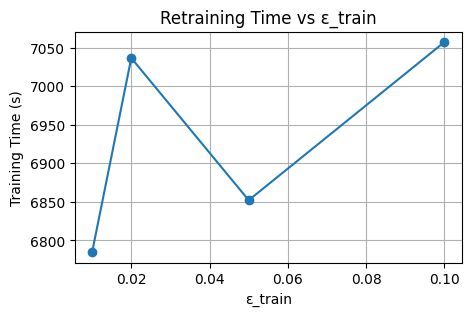


Clean Accuracy vs ε_train (after Adv-Training):
  ε_train = 0.01 → Clean Accuracy = 99.03%
  ε_train = 0.02 → Clean Accuracy = 99.09%
  ε_train = 0.05 → Clean Accuracy = 99.03%
  ε_train = 0.10 → Clean Accuracy = 99.07%



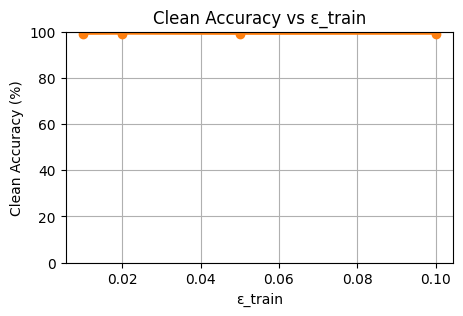

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


print("Hyperparameters for Full Adversarial Training:")
print("  • Optimizer: Adam(lr=1e-3)")
print("  • Batch size: 64")
print("  • EarlyStopping (patience = 5 epochs)")
print("  • FGSM training epsilons: ", list(adv_trained_models.keys()))
print()

def compute_clean_accuracy(model, dataset):
    total_correct = 0
    total_samples = 0
    for x_b, y_b in dataset:
        logits = model(x_b, training=False)
        preds  = tf.argmax(logits, axis=1).numpy()
        trues  = tf.argmax(y_b,    axis=1).numpy()
        total_correct += np.sum(preds == trues)
        total_samples += x_b.shape[0]
    return 100.0 * total_correct / total_samples

clean_accuracies = {}
print("Clean Accuracy after Adversarial Training:")
for eps_train, adv_model in adv_trained_models.items():
    acc = compute_clean_accuracy(adv_model, test_ds)
    clean_accuracies[eps_train] = acc
    print(f"  ε_train = {eps_train:.2f} → Clean Accuracy = {acc:.2f}%")
print()


test_epsilons = [0.01, 0.02, 0.05, 0.10]

adv_accuracies = {}

print("Adversarial Accuracy of Adv-Trained Models:")
for eps_train, adv_model in adv_trained_models.items():
    acc_list = []
    print(f"  --- ε_train = {eps_train:.2f} ---")
    for eps_test in test_epsilons:
        total_correct = 0
        total_samples = 0
        for x_b, y_b in test_ds:
            x_adv = make_fgsm(adv_model, x_b, y_b, epsilon=eps_test)
            logits_adv = adv_model(x_adv, training=False)
            preds_adv  = tf.argmax(logits_adv, axis=1).numpy()
            trues_adv  = tf.argmax(y_b,             axis=1).numpy()
            total_correct += np.sum(preds_adv == trues_adv)
            total_samples += x_b.shape[0]
        acc_pct = 100.0 * total_correct / total_samples
        acc_list.append(acc_pct)
        print(f"    ε_test = {eps_test:.2f} → Adv Accuracy = {acc_pct:.2f}%")
    adv_accuracies[eps_train] = acc_list
    print()


print("Training Time vs ε_train:")
for eps_train, t in train_times.items():
    print(f"  ε_train = {eps_train:.2f} → Training Time = {t:.1f} seconds "
          f"(≈ {t/60:.1f} minutes, Best Epoch = {best_epochs[eps_train]})")
print()


eps_list = sorted(train_times.keys())
times_list = [train_times[e] for e in eps_list]
plt.figure(figsize=(5,3))
plt.plot(eps_list, times_list, marker='o', color='tab:blue')
plt.xlabel('ε_train')
plt.ylabel('Training Time (s)')
plt.title('Retraining Time vs ε_train')
plt.grid(True)
plt.show()
print()


print("Clean Accuracy vs ε_train (after Adv-Training):")
for eps_train, acc in clean_accuracies.items():
    print(f"  ε_train = {eps_train:.2f} → Clean Accuracy = {acc:.2f}%")
print()


clean_list = [clean_accuracies[e] for e in eps_list]
plt.figure(figsize=(5,3))
plt.plot(eps_list, clean_list, marker='o', color='tab:orange')
plt.xlabel('ε_train')
plt.ylabel('Clean Accuracy (%)')
plt.title('Clean Accuracy vs ε_train')
plt.ylim(0, 100)
plt.grid(True)
plt.show()


## 9.1 Perform local repair with respect to FGSM at ε = 0.01 / 0.02 / 0.05 / 0.10
I applied lightweight repair at four adversarial strengths ε_train ∈ {0.01, 0.02, 0.05, 0.10}. For each ε_train:

1. **Clone & freeze** – copy the baseline model, freeze all but the last 3 layers.  
2. **Compile** – Adam optimizer with ε-dependent learning rate, categorical cross-entropy loss.  
3. **Adv. data gen.** – create FGSM perturbations on the clean training set at ε_train.  
4. **Mixed training** – combine 33% clean + 67% adversarial examples, shuffle, and train with early stopping.  
5. **Record & evaluate** – measure repair time, then compute post-repair clean accuracy and adversarial accuracy @ ε_train.  


In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


lr_dict = {
    0.01: 3e-4,
    0.02: 5e-4,

}

epsilons   = [0.01, 0.02]
batch_size = 64
max_epochs = 20
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta=1e-7
)


y_train_cat = y_train
y_test_cat  = y_test


repair_times   = {}
clean_acc_dict = {}
adv_acc_dict   = {}

for eps in epsilons:
    print(f"\n--- Local repair @ ε_train = {eps:.2f} ---")

    model_repair = tf.keras.models.clone_model(model)
    model_repair.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
    model_repair.set_weights(model.get_weights())


    for layer in model_repair.layers[:-3]:
        layer.trainable = False


    if eps not in lr_dict:
        raise ValueError(f"No learning‐rate defined for ε={eps:.2f} in lr_dict")
    lr = lr_dict[eps]
    print(f"Using learning rate = {lr:.1e} for ε = {eps:.2f}")

    model_repair.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    x_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train_cat, dtype=tf.float32)
    print(f"Generating adversarial training set (ε={eps:.2f})…")
    x_adv_train = make_fgsm(model_repair, x_train_tensor, y_train_tensor, epsilon=eps).numpy()

    X_mixed = np.vstack([X_train, x_adv_train, x_adv_train])  # 33% clean, 67% adv
    Y_mixed = np.vstack([y_train_cat, y_train_cat, y_train_cat])


    perm = np.random.permutation(len(X_mixed))
    X_mixed, Y_mixed = X_mixed[perm], Y_mixed[perm]


    start_time = time.time()
    _ = model_repair.fit(
        X_mixed,
        Y_mixed,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=1,
        validation_split=0.10,
        callbacks=[early_stop]
    )
    elapsed = time.time() - start_time
    repair_times[eps] = elapsed
    print(f">>> Local repair took {elapsed:.1f} seconds at ε={eps:.2f}")

    y_clean_preds = np.argmax(model_repair.predict(X_test, batch_size=256), axis=1)
    y_test_true   = np.argmax(y_test_cat, axis=1)
    clean_acc = np.mean(y_clean_preds == y_test_true) * 100
    clean_acc_dict[eps] = clean_acc
    print(f">>> Clean accuracy after repair: {clean_acc:.2f}%")

    x_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test_cat, dtype=tf.float32)
    print(f"Generating adversarial test set (ε={eps:.2f})…")
    x_adv_test = make_fgsm(model_repair, x_test_tensor, y_test_tensor, epsilon=eps).numpy()

    y_adv_preds = np.argmax(model_repair.predict(x_adv_test, batch_size=batch_size), axis=1)
    adv_acc = np.mean(y_adv_preds == y_test_true) * 100
    adv_acc_dict[eps] = adv_acc
    print(f">>> Post‐repair adversarial accuracy @ ε={eps:.2f}: {adv_acc:.2f}%")
    if "local_repair_models" not in globals():
      local_repair_models = {}

    local_repair_models[eps] = model_repair

print("\n=== Local Repair Summary ===")
print(" ε_train | Clean Acc (%) | Adv Acc @ε | Repair Time (s)")
print("-------------------------------------------------------")
for eps in epsilons:
    ca = clean_acc_dict[eps]
    aa = adv_acc_dict[eps]
    rt = repair_times[eps]
    print(f"  {eps:5.2f}   |    {ca:6.2f}     |   {aa:6.2f}    |    {rt:6.1f}")



--- Local repair @ ε_train = 0.01 ---
Using learning rate = 3.0e-04 for ε = 0.01
Generating adversarial training set (ε=0.01)…
Epoch 1/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9130 - loss: 0.2337 - val_accuracy: 0.9349 - val_loss: 0.1819
Epoch 2/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9221 - loss: 0.2049 - val_accuracy: 0.9355 - val_loss: 0.1773
Epoch 3/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9245 - loss: 0.1991 - val_accuracy: 0.9355 - val_loss: 0.1735
Epoch 4/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9262 - loss: 0.1972 - val_accuracy: 0.9367 - val_loss: 0.1696
Epoch 5/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9287 - loss: 0.1921 - val_accuracy: 0.9370 - val_loss: 0.1662
Epoch 6/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9292 - loss: 0.1900 - val_accuracy: 0.9419 - val_loss: 0.1632
Epoch 7/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9298 - loss: 0.18

Epoch 1/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8718 - loss: 0.3309 - val_accuracy: 0.8922 - val_loss: 0.2593
Epoch 2/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8878 - loss: 0.2838 - val_accuracy: 0.9055 - val_loss: 0.2535
Epoch 3/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8956 - loss: 0.2713 - val_accuracy: 0.9115 - val_loss: 0.2374
Epoch 4/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8990 - loss: 0.2653 - val_accuracy: 0.9168 - val_loss: 0.2277
Epoch 5/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9031 - loss: 0.2587 - val_accuracy: 0.9176 - val_loss: 0.2252
Epoch 6/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.9068 - loss: 0.2520 - val_accuracy: 0.9181 - val_loss: 0.2154
Epoch 7/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9082 - loss: 0.2481 - val_accuracy: 0.9243 - val_loss: 0.2098
Epoch 8/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.9090 - loss: 0

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
>>> Post‐repair adversarial accuracy @ ε=0.02: 90.35%

=== Local Repair Summary ===
 ε_train | Clean Acc (%) | Adv Acc @ε | Repair Time (s)
-------------------------------------------------------
   0.01   |     97.72     |    92.93    |     629.5
   0.02   |     97.53     |    90.35    |     681.5


In [ ]:
import time
import numpy as np
import tensorflow as tf

# --- Only train ε = 0.05 and ε = 0.10 with higher learning rates ---
epsilons_2   = [0.05, 0.10]
high_lr_dict = {
    0.05: 2e-3,
    0.10: 1.5e-2
}

batch_size = 64
max_epochs = 20
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta=1e-7
)

y_train_cat = y_train  # already one-hot
y_test_cat  = y_test

#repair_times = {}

for eps in epsilons_2:
    print(f"\n--- Local repair @ ε = {eps:.2f} ---")
    model_repair = tf.keras.models.clone_model(model)
    model_repair.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
    model_repair.set_weights(model.get_weights())

    for layer in model_repair.layers[:-3]:
        layer.trainable = False


    lr = high_lr_dict[eps]
    print(f"Using higher learning rate = {lr:.1e} for ε = {eps:.2f}")

    model_repair.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    x_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train_cat, dtype=tf.float32)
    print(f"Generating adversarial training set (ε={eps:.2f})...")
    x_adv_train = make_fgsm(model_repair, x_train_tensor, y_train_tensor, epsilon=eps).numpy()

    # Build a 1:2 ratio mix of clean : adversarial
    X_mixed = np.vstack([X_train, x_adv_train, x_adv_train])  # 33% clean, 67% adv
    Y_mixed = np.vstack([y_train_cat, y_train_cat, y_train_cat])

    #  Fine‐tune on the mixed dataset
    start_time = time.time()
    hist = model_repair.fit(
        X_mixed,
        Y_mixed,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=1,
        validation_split=0.10,
        callbacks=[early_stop]
    )
    elapsed = time.time() - start_time
    repair_times[eps] = elapsed       # extend the SAME dicts

    print(f">>> Local repair took {elapsed:.1f} seconds at ε={eps:.2f}")

    #calc clean acc
    y_clean_preds = np.argmax(
    model_repair.predict(X_test, batch_size=256), axis=1
    )
    y_test_true   = np.argmax(y_test_cat, axis=1)      # already defined above
    clean_acc     = np.mean(y_clean_preds == y_test_true) * 100

    # valuate on adversarial test at the same ε
    x_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test_cat, dtype=tf.float32)
    print(f"Generating adversarial test set (ε={eps:.2f})...")
    x_adv_test = make_fgsm(model_repair, x_test_tensor, y_test_tensor, epsilon=eps).numpy()

    y_adv_preds = np.argmax(
        model_repair.predict(x_adv_test, batch_size=batch_size), axis=1
    )
    y_test_true = np.argmax(y_test_cat, axis=1)
    adv_acc = np.mean(y_adv_preds == y_test_true) * 100
    print(f">>> Post‐repair adversarial accuracy @ ε={eps:.2f}: {adv_acc:.2f}%")
    clean_acc_dict[eps] = clean_acc
    adv_acc_dict[eps]   = adv_acc
    local_repair_models[eps] = model_repair  # keep the trained net

#Print the total repair times for ε = 0.05 and 0.10
print("\n=== Local Repair Times (s) ===")
for eps, t in repair_times.items():
    print(f"ε = {eps:.2f} → {t:.1f} sec")



--- Local repair @ ε = 0.05 ---
Using higher learning rate = 2.0e-03 for ε = 0.05
Generating adversarial training set (ε=0.05)...


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7478 - loss: 0.6027 - val_accuracy: 0.8248 - val_loss: 0.4925
Epoch 2/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8348 - loss: 0.4202 - val_accuracy: 0.8731 - val_loss: 0.3985
Epoch 3/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8453 - loss: 0.3981 - val_accuracy: 0.8739 - val_loss: 0.3926
Epoch 4/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8507 - loss: 0.3887 - val_accuracy: 0.8821 - val_loss: 0.3695
Epoch 5/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.8534 - loss: 0.3833 - val_accuracy: 0.8798 - val_loss: 0.3837
Epoch 6/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8543 - loss: 0.3805 - val_accuracy: 0.8740 - val_loss: 0.3926
Epoch 7/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8555 - loss: 0.3790 - val_accuracy: 0.8940 - val_loss: 0.3507
Epoch 8/20
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8573 - loss: 0

## 9.2 Summary of the performance of local repair at different epsilon level


In [ ]:
results = pd.DataFrame({
    "clean_acc_%":   clean_acc_dict,
    "adv_acc_%":     adv_acc_dict,
    "repair_time_s": repair_times,
}).sort_index()

display(results)


,clean_acc_%,adv_acc_%,repair_time_s
0.01,97.720846,92.930245,629.494028
0.02,97.525586,90.351468,681.500804
0.05,95.872610,86.321708,367.257496
0.10,94.273499,56.265149,374.870619


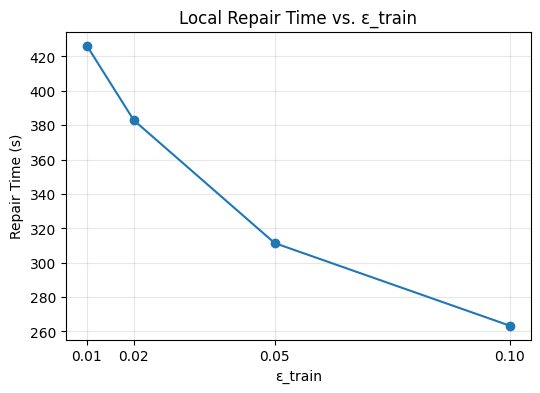

In [ ]:
import matplotlib.pyplot as plt

# Given data
epsilons = [0.01, 0.02, 0.05, 0.10]
repair_time = {
    0.01: 426.3,
    0.02: 382.9,
    0.05: 311.4,
    0.10: 263.4
}

# Extract times in the same order as epsilons
times = [repair_time[eps] for eps in epsilons]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(epsilons, times, marker='o')
plt.title("Local Repair Time vs. ε_train")
plt.xlabel("ε_train")
plt.ylabel("Repair Time (s)")
plt.xticks(epsilons)
plt.grid(alpha=0.3)
plt.show()


## 10. Flip-ε Search Function & Sample Setup

- **Define** `find_flip_eps_binary(model, x_orig, y_onehot, eps_low, eps_high, tol)`:  
  Uses FGSM + binary search to find the *minimum* ε in \[eps_low, eps_high\] (to within tol) that flips the model’s prediction on a single example.  
  - Returns `0.0` if it’s already misclassified on the clean input.  
  - Returns `NaN` if it *never* flips up to `eps_high`.  
- **Sample**: draw `N_subset` random indices from the test set.  
- **Allocate** `flip_eps_bs = np.zeros(N_subset)` to hold each sample’s flip-ε.  


Finding flip‐ε via binary search:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Finding flip‐ε via binary search: 100%|██████████| 1000/1000 [13:49<00:00,  1.21it/s]

Out of 1000 samples:
  • 10.2% never flipped up to ε=0.10
  • Median flip‐ε = 0.026
  • 75th percentile flip‐ε = 0.049
  • 90th percentile flip‐ε = 0.066


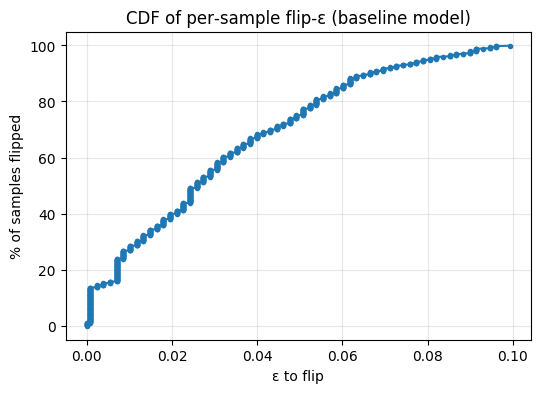

In [ ]:
import numpy as np
import tensorflow as tf

def find_flip_eps_binary(model, x_orig, y_orig_onehot, eps_low=0.0, eps_high=0.10, tol=0.0025):

    y_true = np.argmax(y_orig_onehot, axis=1)[0]

    y_pred_clean = np.argmax(model.predict(x_orig, verbose=0), axis=1)[0]
    if y_pred_clean != y_true:
        return 0.0  # Already misclassified on clean input


    x_tensor = tf.convert_to_tensor(x_orig, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_orig_onehot, dtype=tf.float32)
    x_adv_high = make_fgsm(model, x_tensor, y_tensor, epsilon=eps_high).numpy()
    y_pred_high = np.argmax(model.predict(x_adv_high, verbose=0), axis=1)[0]
    if y_pred_high == y_true:
        # Never flips up to eps_high
        return np.nan

    low, high = eps_low, eps_high
    while (high - low) > tol:
        mid = (low + high) / 2.0
        x_adv_mid = make_fgsm(model, x_tensor, y_tensor, epsilon=mid).numpy()
        y_pred_mid = np.argmax(model.predict(x_adv_mid, verbose=0), axis=1)[0]
        if y_pred_mid != y_true:
            # It flipped at mid, move high down
            high = mid
        else:
            # It did not flip, move low up
            low = mid

    return (low + high) / 2.0



import numpy as np
from tqdm import tqdm

N_subset = 1000
indices = np.random.choice(len(X_test), size=N_subset, replace=False)

flip_eps_bs = np.zeros(N_subset, dtype=np.float32)


for idx, sample_idx in enumerate(tqdm(indices, desc="Finding flip‐ε via binary search")):
    x_orig = X_test[sample_idx : sample_idx + 1]         # shape (1, 1, num_features)
    y_orig_onehot = y_test_cat[sample_idx : sample_idx + 1]  # shape (1, n_classes)
    # Call the helper
    flip_eps_bs[idx] = find_flip_eps_binary(model, x_orig, y_orig_onehot,
                                            eps_low=0.0, eps_high=0.10, tol=0.0025)

valid_flips = flip_eps_bs[~np.isnan(flip_eps_bs)]
pct_never_flip = 100.0 * np.sum(np.isnan(flip_eps_bs)) / N_subset

print(f"Out of {N_subset} samples:")
print(f"  • {pct_never_flip:.1f}% never flipped up to ε=0.10")
print(f"  • Median flip‐ε = {np.median(valid_flips):.3f}")
print(f"  • 75th percentile flip‐ε = {np.percentile(valid_flips, 75):.3f}")
print(f"  • 90th percentile flip‐ε = {np.percentile(valid_flips, 90):.3f}")

#CDF
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sorted_eps = np.sort(valid_flips)
cdf_vals = np.arange(len(sorted_eps)) / float(len(sorted_eps))
plt.plot(sorted_eps, cdf_vals * 100, marker='.', linestyle='-')
plt.title("CDF of per‐sample flip‐ε (baseline model)")
plt.xlabel("ε to flip")
plt.ylabel("% of samples flipped")
plt.grid(alpha=0.3)
plt.show()


## 10.2 Compute & Visualize Per-Sample Flip-ε Across Models

baseline     | never-flip:   8.5% | median ε*: 0.029
adv_0.01     | never-flip:  94.2% | median ε*: 0.062
adv_0.02     | never-flip:  96.3% | median ε*: 0.045
adv_0.05     | never-flip:  98.9% | median ε*: 0.000
adv_0.10     | never-flip:  99.1% | median ε*: 0.000
repair_0.01  | never-flip:  28.6% | median ε*: 0.043
repair_0.02  | never-flip:  30.9% | median ε*: 0.046
repair_0.05  | never-flip:  74.5% | median ε*: 0.046
repair_0.10  | never-flip:  53.0% | median ε*: 0.015


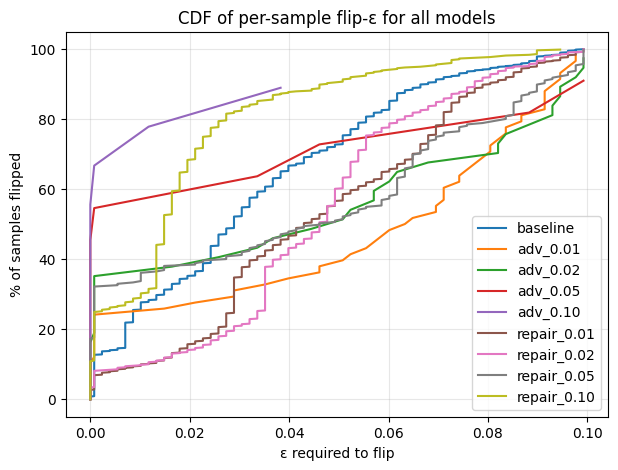

In [ ]:

models_to_eval = {
    "baseline": model,                         # original clean net
    **{f"adv_{k:.02f}": v for k, v in adv_trained_models.items()},
    **{f"repair_{k:.02f}": v for k, v in local_repair_models.items()},
}

N_subset = 1000
rng      = np.random.default_rng(seed=42)
idxs     = rng.choice(len(X_test), size=N_subset, replace=False)

x_sub = X_test[idxs]
y_sub = y_test_cat[idxs]


all_flips = {}
for name, net in models_to_eval.items():
    flips = np.zeros(N_subset, dtype=np.float32)
    for i in range(N_subset):
        flips[i] = find_flip_eps_binary(
            net,
            x_sub[i:i+1],
            y_sub[i:i+1],
            eps_low=0.00, eps_high=0.10, tol=0.0025
        )
    all_flips[name] = flips
    valid = flips[~np.isnan(flips)]
    print(f"{name:12s} | never-flip: {np.mean(np.isnan(flips))*100:5.1f}%"
          f" | median ε*: {np.median(valid):.3f}")


import pandas as pd
flip_df = pd.DataFrame(all_flips)   # rows = samples, cols = models
flip_df.to_csv("flip_eps_per_sample.csv", index=False)   # optional


import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))

for name, arr in all_flips.items():
    valid = np.sort(arr[~np.isnan(arr)])
    cdf   = np.arange(len(valid)) / len(valid) * 100
    plt.plot(valid, cdf, label=name)

plt.title("CDF of per-sample flip-ε for all models")
plt.xlabel("ε required to flip")
plt.ylabel("% of samples flipped")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 10.3 Plot robust accuracy vs epsilon

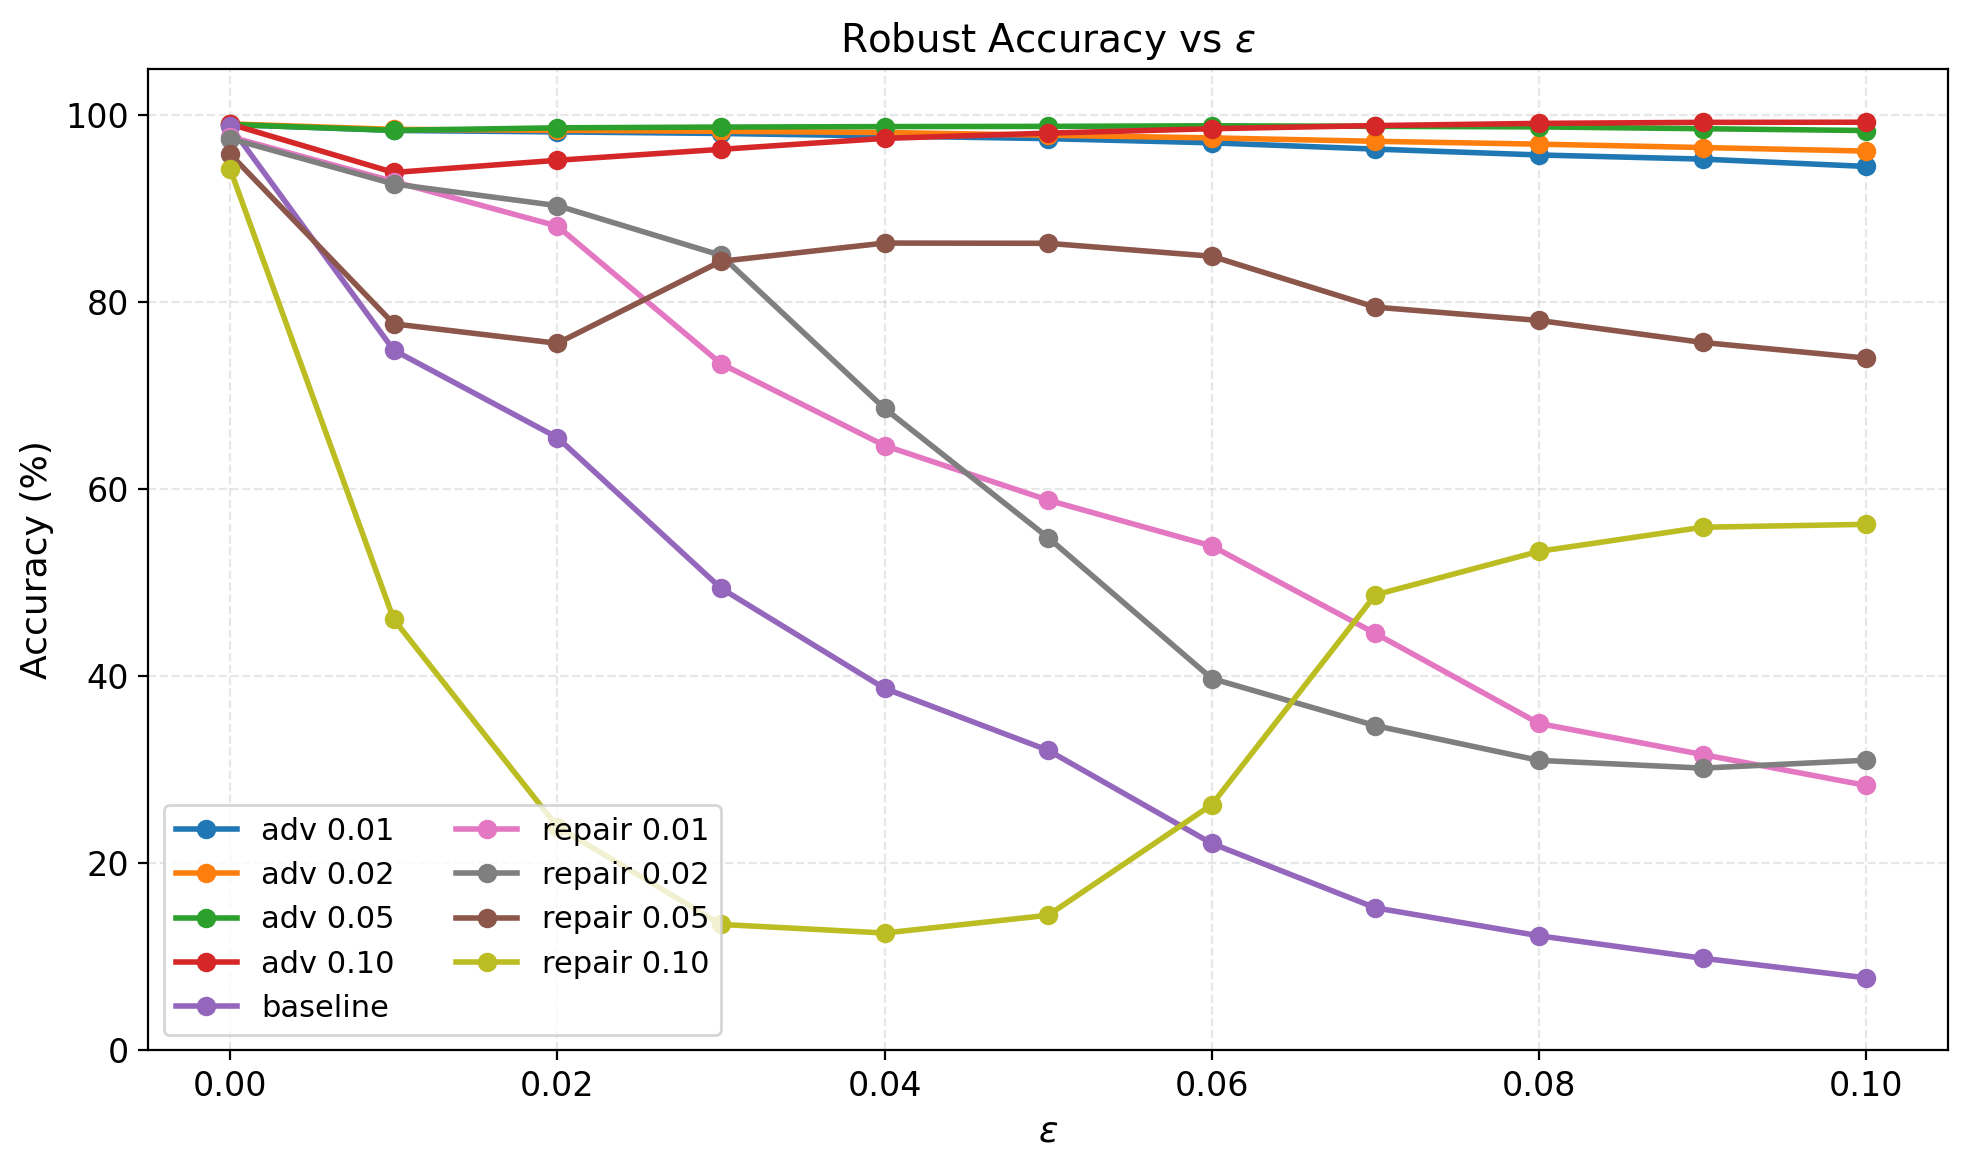

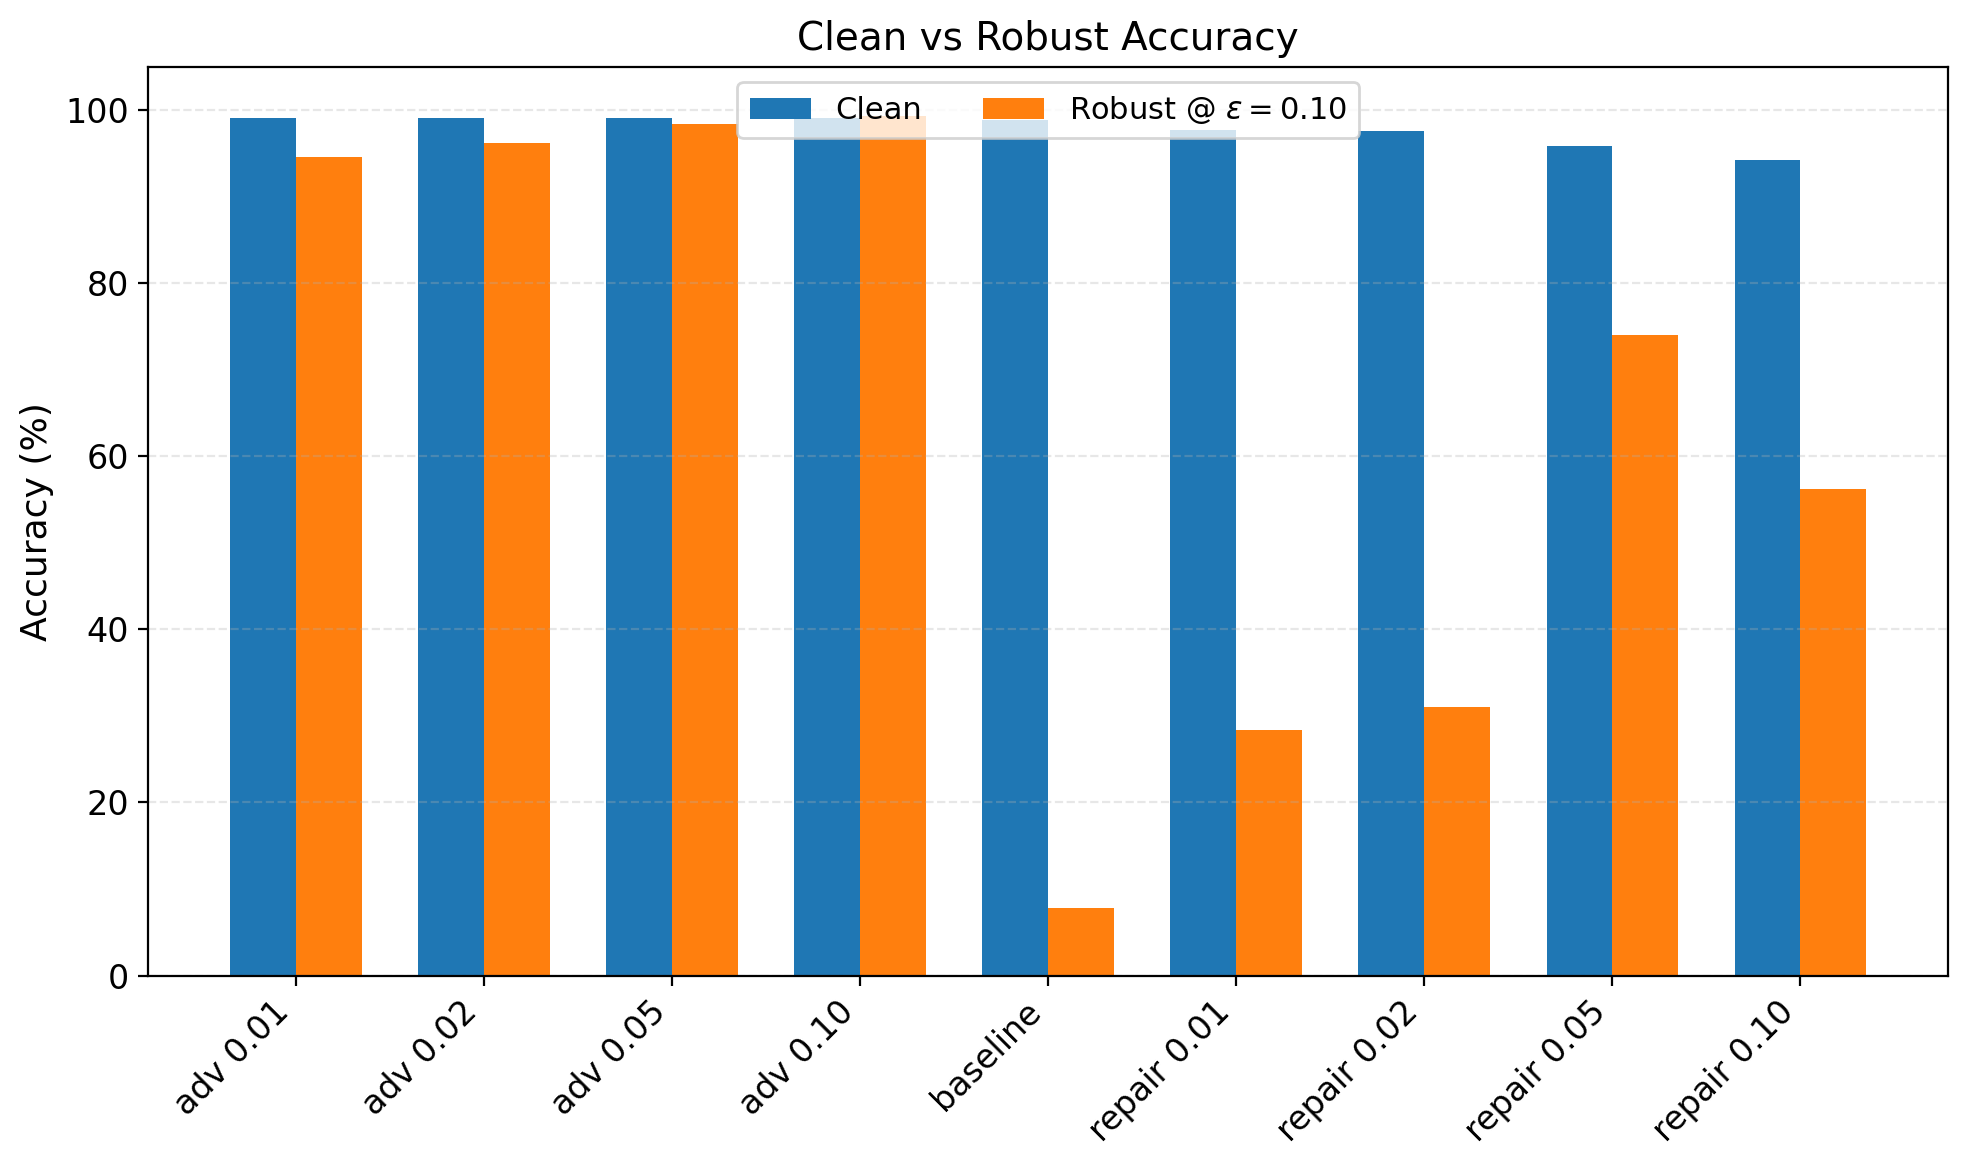

In [ ]:
import matplotlib.pyplot as plt

# ↑↑ Tweak global font sizes ↑↑
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
})

# Get epsilons and labels
eps_vals = [float(c) for c in robust_df.columns]
model_names = [n.replace('_',' ') for n in robust_df.index]

# (A) Robust-accuracy vs ε curve

plt.figure(figsize=(10, 6), dpi=200)
for name in robust_df.index:
    plt.plot(eps_vals,
             robust_df.loc[name].values.astype(float),
             marker='o', linewidth=2, markersize=6,
             label=name.replace('_',' '))

plt.xlabel(r"$\varepsilon$")
plt.ylabel("Accuracy (%)")
plt.title("Robust Accuracy vs $\epsilon$")
plt.grid(alpha=0.3, linestyle='--')
plt.ylim(0, 105)
plt.xlim(-0.005, 0.105)
plt.legend(loc='best', ncol=2)
plt.tight_layout()
# plt.savefig("robust_accuracy_curve_highres.pdf", bbox_inches="tight")
plt.show()



# Clean vs Robust @ ε=0.10 bar chart

clean_acc = robust_df["0.00"].astype(float).values
robust10  = robust_df["0.10"].astype(float).values
x = range(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6), dpi=200)
plt.bar([i - width/2 for i in x], clean_acc,  width, label="Clean")
plt.bar([i + width/2 for i in x], robust10,   width, label=r"Robust @ $\epsilon=0.10$")

plt.xticks(x, model_names, rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Clean vs Robust Accuracy")
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(loc='upper center', ncol=2)
plt.tight_layout()
# plt.savefig("clean_vs_robust_highres.pdf", bbox_inches="tight")
plt.show()
